# Classificação de Atividade Humana com PCA

# <a id='sumario'></a>Sumário
1. [**Entendimento do problema**](#entendimento-do-problema)
2. [**Bibliotecas**](#bibliotecas)
<br>
3. [**Entendimento dos Dados**](#entendimento-dos-dados)       
- 3.1 [Carregando os Dados](#carregando-os-dados)
- 3.2 [Primeiras impressões dos dados](#primeiras-impressoes-dos-dados)

4. [**PCA**](#PCA)
- 4.1 [Padronização PCA](#pad-PCA)
- 4.2 [Descritiva PCA e PAD](#descritiva-pad)
5. [**Descritiva LDA**](#LDA)
6. [**Planejamento do Modelo**](#setup)
- 6.1 [Setup](#setup)
- 6.2 [compare_models](#compare_models)
<br>
7. [**Modelo Final**](#modelo-final)<br>
- 7.1 [create_model](#create_model)
- 7.2 [Predict e Pipeline](#Predict-Pipeline)
<br>
8. [**Avaliação do Modelo**](#aval-modelo)
9. [**Relatório Gerencial**](#Relatorio)

<a id='entendimento-do-problema'></a>
# 1. Entendimento do problema

Este projeto envolve a criação de um modelo para prever a atividade humana com base em dados de sensores. As atividades que estamos tentando prever são as seguintes:

1. **Caminhando** (WALKING)
2. **Subindo escadas** (WALKING_UPSTAIRS)
3. **Descendo escadas** (WALKING_DOWNSTAIRS)
4. **Sentado** (SITTING)
5. **Em pé** (STANDING)
6. **Deitado** (LAYING)

Os dados para este projeto vêm de sinais brutos do acelerômetro e giroscópio 3-axial. Esses sinais foram capturados a uma taxa constante de 50 Hz e foram filtrados para remover o ruído. Além disso, o sinal de aceleração foi separado em sinais de aceleração do corpo e da gravidade. A partir desses sinais, várias variáveis foram estimadas para criar um vetor de recursos para cada padrão.

Modelos como este são comumente usados em smartphones e smartwatches. Eles são importantes porque fornecem informações valiosas sobre a atividade física e a saúde do usuário. Por exemplo, eles podem ajudar a monitorar a quantidade de tempo que um usuário passa em diferentes tipos de atividades físicas, o que pode ser útil para rastrear a saúde e o condicionamento físico.

<a id='bibliotecas'></a>
# 2. Bibliotecas

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from ydata_profiling import ProfileReport
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from pycaret.classification import *

<a id='entendimento-dos-dados'></a>
# 3. Entendimento dos Dados

Os dados para este projeto são importados de vários arquivos. Cada arquivo contém uma parte específica dos dados que serão usados para treinar e testar o modelo.

Os nomes das variáveis explicativas, que são 561 no total, estão armazenados no arquivo 'features.txt'. Cada linha neste arquivo representa o nome de uma variável explicativa.

As labels, que representam as atividades que estamos tentando prever, estão armazenadas no arquivo 'activity_labels.txt'. As atividades são as seguintes:

1. **Caminhando** (WALKING)
2. **Subindo escadas** (WALKING_UPSTAIRS)
3. **Descendo escadas** (WALKING_DOWNSTAIRS)
4. **Sentado** (SITTING)
5. **Em pé** (STANDING)
6. **Deitado** (LAYING)

Os dados de treinamento estão divididos em três arquivos: 'subject_train.txt', 'X_train.txt' e 'y_train.txt'. O arquivo 'subject_train.txt' contém os IDs dos sujeitos para o conjunto de treinamento. O arquivo 'X_train.txt' contém os dados de treinamento para as variáveis explicativas. O arquivo 'y_train.txt' contém os dados de treinamento para as labels.

Da mesma forma, os dados de teste estão divididos em três arquivos: 'subject_test.txt', 'X_test.txt' e 'y_test.txt'. O arquivo 'subject_test.txt' contém os IDs dos sujeitos para o conjunto de teste. O arquivo 'X_test.txt' contém os dados de teste para as variáveis explicativas. O arquivo 'y_test.txt' contém os dados de teste para as labels.

Esses dados são lidos e armazenados em dataframes do pandas para posterior análise e modelagem. A separação dos dados em conjuntos de treinamento e teste permite que o modelo seja treinado em um conjunto de dados e depois testado em um conjunto de dados separado. Isso ajuda a garantir que o modelo seja capaz de generalizar bem para novos dados.

Todos esses arquivos podem ser encontrados no seguinte link: https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones

<a id='carregando-os-dados'></a>
## 3.1 Carregando os Dados

In [2]:
filename_features = "./Dados/UCI HAR Dataset/features.txt"
filename_labels = "./Dados/UCI HAR Dataset/activity_labels.txt"

filename_subtrain = "./Dados/UCI HAR Dataset/train/subject_train.txt"
filename_xtrain = "./Dados/UCI HAR Dataset/train/X_train.txt"
filename_ytrain = "./Dados/UCI HAR Dataset/train/y_train.txt"

filename_subtest = "./Dados/UCI HAR Dataset/test/subject_test.txt"
ffilename_xtest = "./Dados/UCI HAR Dataset/test/X_test.txt"
filename_ytest = "./Dados/UCI HAR Dataset/test/y_test.txt"

features = pd.read_csv(filename_features, header=None, names=['nome_var'], sep="#")
labels = pd.read_csv(filename_labels, delim_whitespace=True, header=None, names=['cod_label', 'label'])

subject_train = pd.read_csv(filename_subtrain, header=None, names=['subject_id'])
X_train = pd.read_csv(filename_xtrain, delim_whitespace=True, header=None, names=features['nome_var'].tolist())
y_train = pd.read_csv(filename_ytrain, header=None, names=['cod_label'])

subject_test = pd.read_csv(filename_subtest, header=None, names=['subject_id'])
X_test = pd.read_csv(ffilename_xtest, delim_whitespace=True, header=None, names=features['nome_var'].tolist())
y_test = pd.read_csv(filename_ytest, header=None, names=['cod_label'])

In [3]:
# Criando o dataframe de treinamento
df_train = pd.concat([subject_train, X_train, y_train], axis=1)

# Criando o dataframe de teste
df_test = pd.concat([subject_test, X_test], axis=1)

<a id='primeiras-impressoes-dos-dados'></a>
## 3.2 Primeiras imprensões dos dados

In [4]:
# Obtém o tamanho dos dados
df_train.shape

(7352, 563)

In [5]:
# Obtém a quantidade de cada tipo de variável
types = df_train.dtypes.value_counts()

# Cria um dataframe para armazenar os resultados
profile = pd.DataFrame({'Tipo': types.index, 'Quantidade': types.values})

# Para cada tipo de variável, se houver menos de 4 variáveis desse tipo,
# adiciona os nomes dessas variáveis ao dataframe de resultados
for dtype in profile['Tipo']:
    if profile.loc[profile['Tipo'] == dtype, 'Quantidade'].values[0] < 4:
        var_names = df_train.select_dtypes(include=[dtype]).columns.tolist()
        profile.loc[profile['Tipo'] == dtype, 'Variáveis'] = ', '.join(var_names)

profile

,Tipo,Quantidade,Variáveis
0,float64,561,NaN
1,int64,2,"subject_id, cod_label"


- Como vimos, toda base é numérica, até a própria classe foi codificada em: 
1 WALKING
2 WALKING_UPSTAIRS
3 WALKING_DOWNSTAIRS
4 SITTING
5 STANDING
6 LAYING


In [6]:
# Verifica se há dados faltantes
df_train.isnull().sum().sum()

0

<a id='PCA'></a>
# 4. PCA

A Análise de Componentes Principais (PCA) é uma técnica de **redução de dimensionalidade** que é comumente usada em aprendizado de máquina e visualização de dados de alta dimensão. A ideia do PCA é simples — reduzir o número de variáveis de um conjunto de dados, mantendo ao mesmo tempo a maior quantidade possível de informação.

O PCA transforma um grande conjunto de variáveis possivelmente correlacionadas em um conjunto menor de variáveis não correlacionadas chamadas **componentes principais**.

Primeiro, o PCA calcula a **matriz de covariância** dos dados para entender como as variáveis do conjunto de dados estão correlacionadas. Em seguida, o PCA encontra os **autovalores e autovetores** da matriz de covariância. Os autovetores (que correspondem aos autovalores maiores) tornam-se os componentes principais (as novas variáveis) do conjunto de dados.

Matematicamente, se tivermos um conjunto de dados $X$ com variáveis correlacionadas, o PCA encontrará uma matriz de transformação $P$ que irá transformar $X$ em $Y$, onde $Y$ é um conjunto de dados com variáveis não correlacionadas. As linhas de $P$ são os autovetores da matriz de covariância de $X$.

$$Y = PX$$

Neste caso, temos um conjunto de dados com um grande número de variáveis (561 variáveis). Isso pode tornar o processo de treinamento do modelo muito lento e também pode levar a um modelo que é complexo e difícil de interpretar.

Ao aplicar o PCA, podemos reduzir o número de variáveis para um valor menor que ainda retém a maior parte da informação do conjunto de dados original. Isso pode ajudar a **acelerar o treinamento do modelo** e também pode melhorar a **interpretabilidade do modelo**, pois teremos menos variáveis para considerar.

<a id='pad-PCA'></a>
## 4.1 Padronização PCA

Como vimos matemáticamente a escala é importante para a criação das **componentes principais**, no nosso caso, são variéveis vindas do giroscópio e acelerometro, parecem estar em escalas parecidas, porém como são mais de **500 variáveis** explicativas, vale a pena criar um data frame padronizado, e outro como está para valiarmos os resultados.

### Df PCA com padronização

In [32]:
# Importando as bibliotecas necessárias
from sklearn.preprocessing import StandardScaler

# Removendo a variável de resposta e a identificação do voluntário
df_train_features = df_train.drop(['cod_label', 'subject_id'], axis=1)

# Criando o padronizador
scaler = StandardScaler()

# Ajustando e transformando os dados
df_train_pad = scaler.fit_transform(df_train_features)

# Convertendo de volta para um DataFrame
df_train_pad = pd.DataFrame(df_train_pad, columns=df_train_features.columns)

In [44]:
# Criando uma instância do PCA para os dados padronizados
pca_pad = PCA()

# Aplicando PCA aos dados padronizados
princomp_pad = pca_pad.fit(df_train_pad)

# Numero de colunas para nomear componentes
n_componentes_pad = df_train_pad.shape[1]

# Transformando linearmente os dados padronizados
componentes_pad = princomp_pad.transform(df_train_pad)

# Renomeando as componentes
nomes_pca_pad = ['CP'+str(x+1) for x in list(range(n_componentes_pad))]

# DF das CPs com padronização
CP_pad = pd.DataFrame(data = componentes_pad, columns = nomes_pca_pad)

### Df PCA sem padronização

In [45]:
# Criando uma instância do PCA para os dados originais
pca = PCA()

# Aplicando PCA aos dados originais
princomp = pca.fit(df_train_features)

# Numero de colunas para nomear componentes
n_componentes = df_train_features.shape[1]

# Transformando linearmente os dados sem padronização
componentes = princomp.transform(df_train_features)

# Renomeando as componentes
nomes_pca = ['CP'+str(x+1) for x in list(range(n_componentes))]

# DF das CPs sem padronização
CP = pd.DataFrame(data = componentes, columns = nomes_pca)

<a id='descritiva-pad'></a>
## 4.2 Descritiva PCA e PAD

### A variância explicada por componente:

A **variância explicada** em PCA é a proporção da variação total nos dados que é capturada por um componente. Quanto maior a variância explicada, mais informações ou 'variação' são capturadas pelo componente. Portanto, um valor maior é geralmente melhor, pois significa que mais da estrutura subjacente nos dados está sendo capturada.

In [46]:
# A variância dos auto vetores são os auto valores, variância do PCA não padronizado
var_exp = princomp.explained_variance_
var_exp[0]

34.82363040636603

In [47]:
# Variância do PCA padronizado
var_exp_pad = princomp_pad.explained_variance_
var_exp_pad[0]

284.92113078844505

### A variância explicada acumulada por componente: 

In [48]:
#A variância dos auto vetores são os auto valores, cumsum() é a soma acumulada de cada componente

# Variância acumulada do PCA não padronizado
var_exp_cumsum = princomp.explained_variance_.cumsum()

# Variância acumulada do PCA padronizado
var_exp_cumsum_pad = princomp_pad.explained_variance_.cumsum()

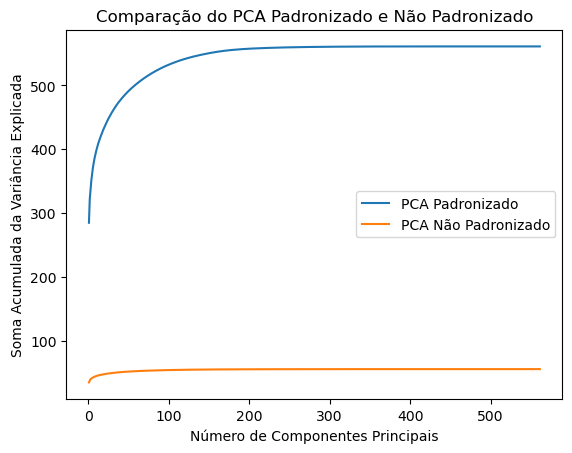

In [49]:
# Número de componentes principais
num_componentes_cumsum = len(var_exp_cumsum_pad)

# Números de componentes para o eixo x
componentes_cumsum = range(1, num_componentes_cumsum + 1)

# Plotando o gráfico de linha
plt.plot(componentes_cumsum, var_exp_cumsum_pad, label='PCA Padronizado')
plt.plot(componentes_cumsum, var_exp_cumsum, label='PCA Não Padronizado')

# Configurações do gráfico
plt.xlabel('Número de Componentes Principais')
plt.ylabel('Soma Acumulada da Variância Explicada')
plt.title('Comparação do PCA Padronizado e Não Padronizado')
plt.legend()

# Exibindo o gráfico
plt.show()

- Nota-se o quanto o PCA padronizado explica mais com menos componentes

### A variância percentual acumulada por componente: 

In [52]:
# Percentual da variância do PCA não padronizado
var_perc = princomp.explained_variance_ratio_

# Percentual da variância do PCA padronizado
var_perc_pad = princomp_pad.explained_variance_ratio_

# Percentual da variância acumulada do PCA não padronizado
var_cumperc = princomp.explained_variance_ratio_.cumsum()

# Percentual da variância acumulada do PCA padronizado
var_cumperc_pad = princomp_pad.explained_variance_ratio_.cumsum()

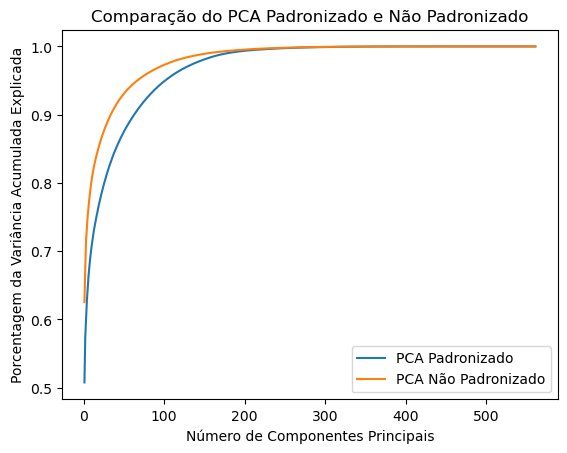

In [53]:
# Número de componentes principais
num_componentes_cumperc = len(var_cumperc_pad)

# Números de componentes para o eixo x
componentes_cumperc = range(1, num_componentes_cumperc + 1)

# Plotando o gráfico de linha
plt.plot(componentes_cumperc, var_cumperc_pad, label='PCA Padronizado')
plt.plot(componentes_cumperc, var_cumperc, label='PCA Não Padronizado')

# Configurações do gráfico
plt.xlabel('Número de Componentes Principais')
plt.ylabel('Porcentagem da Variância Acumulada Explicada')
plt.title('Comparação do PCA Padronizado e Não Padronizado')
plt.legend()


# Exibindo o gráfico
plt.show()

In [74]:
# O número de componentes necessárias para atingir 90% de variância explicada com o PCA não padronizado
objetivo = 0.90
num_components = np.argmax(var_cumperc >= objetivo)

print(f"Número de componentes sem PAD necessárias para atingir {objetivo*100}% de variância explicada: {num_components}")

Número de componentes sem PAD necessárias para atingir 90.0% de variância explicada: 33


In [73]:
# O número de componentes necessárias para atingir 90% de variância explicada com o PCA padronizado
objetivo = 0.90
num_components = np.argmax(var_cumperc_pad >= objetivo)

print(f"Número de componentes com PAD necessárias para atingir {objetivo*100}% de variância explicada: {num_components}")

Número de componentes com PAD necessárias para atingir 90.0% de variância explicada: 62


-  Vemos que o PCA padronizado sobe mais lentamente que o não padronizado, porém bate 90% bem próximo um do outro. Isso faz sentido pela estrutura inicial dos dados, os dados já vem com padrões dos sensores, e bem estruturados. Vamos avaliar os dois em teste !

<a id='LDA'></a>
# 5. Descritiva LDA

A **Análise Discriminante Linear (LDA)** é uma técnica estatística usada para encontrar uma combinação linear de características que caracterizam ou separam duas ou mais classes de objetos ou eventos. A ideia é projetar um conjunto de dados em um espaço de menor dimensão com boa separação de classe para evitar a maldição da dimensionalidade ao mesmo tempo em que se mantém o máximo de informações relevantes.

Matematicamente, a LDA mapeia dados de entrada $$x$$ em um espaço de saída $$y$$ através de uma função discriminante:

$$y = w^Tx$$

onde $$w$$ é o vetor de pesos.

O objetivo da LDA é maximizar a distância entre as médias das duas classes (chamada de distância entre classes ou **scatter between**) enquanto minimiza a variância dentro de cada classe (chamada de scatter dentro da classe ou **scatter within**). Isso é feito através da seguinte função objetivo:

$$J(w) = \frac{w^TS_Bw}{w^TS_Ww}$$

onde $$S_B$$ é a matriz de scatter between e $$S_W$$ é a matriz de scatter within.

A solução para essa função objetivo é dada pelo problema de autovalores:

$$S_W^{-1}S_Bw = \lambda w$$

Os autovetores correspondentes aos maiores autovalores são os que formam o espaço de características discriminantes.

Como vimos as **62 primeiras variáveis principais, explicam 90 % dos dados** e para isso vamos usar a LDA nessas 62


In [75]:
# Criando uma instância do LDA
lda = LDA()

# Mapeando y_train para as labels de string
dict_classes = {1: 'Caminhando', 2: 'Subindo Escadas', 3: 'Descendo Escadas', 4: 'Sentado', 5: 'Em Pé', 6: 'Deitado'}
classes_str = y_train['cod_label'].map(dict_classes)

# Selecionando apenas as primeiras 62 componentes principais
CP_pad_62 = CP_pad.iloc[:, :62]

# Ajustando o modelo LDA
lda.fit(CP_pad_62, classes_str)

# Obtendo as três variáveis mais importantes para cada classe
top_vars = {}
for i, class_name in enumerate(lda.classes_):
    top_vars[class_name] = np.argsort(np.abs(lda.coef_[i]))[-3:]

# Criando um DataFrame com os dados
data = []
for class_name, vars in top_vars.items():
    for var in vars:
        data.append({
            'Classe': class_name,
            'Variável': 'CP'+str(var+1),
        })
df_top_vars = pd.DataFrame(data)

# Criando o gráfico de barras
fig = px.scatter(df_top_vars, x='Classe', y='Variável', title='Três Variáveis Mais Importantes por Classe')

# Mostrando o gráfico
fig.show()

- Vemos que as mais importantes componenetes para explicar todas as classes são apenas 8, e que diferem bem entre si, demonstrando um diferenciação boa entre as classes.

<a id='planejamento-modelo'></a>
# 6. Planejamento do Modelo

Como observamos se trata de um problema de **classificação multiclasse** e de longa dimensão de variáveis explicativas, vamos avaliar a aplicação de algoritmos para bases padronizadas e não padronizadas.

<a id='setup'></a>
## 6.1 Setup

O setup do módulo `Pycaret` cria um ambiente que ajuda na criaçaõ de modeos, vamos usá-lo apra comparar algoritmos.

In [76]:
# Adicionando as labels nos dfs
CP = CP.assign(label=y_train)
CP_pad = CP_pad.assign(label=y_train)

In [81]:
# Selecionando apenas as primeiras 62 colunas
CP_pad_62 = CP_pad.iloc[:, :62]

# Adicionando a coluna 'label'
CP_pad_62 = CP_pad_62.assign(label=y_train)

In [82]:
# Inicializando o setup
setup(data = CP_pad_62, target = 'label')

,Description,Value
0,Session id,484
1,Target,label
2,Target type,Multiclass
3,Target mapping,"1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5"
4,Original data shape,"(7352, 63)"
5,Transformed data shape,"(7352, 63)"
6,Transformed train set shape,"(5146, 63)"
7,Transformed test set shape,"(2206, 63)"
8,Numeric features,62
9,Preprocess,True


<a id='compare_models'></a>
## 6.2 compare_models

In [83]:
# Comparando todos os modelos
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9555,0.9968,0.9555,0.9559,0.9555,0.9464,0.9465,11.3850
qda,Quadratic Discriminant Analysis,0.9437,0.9951,0.9437,0.9468,0.9431,0.9322,0.9331,7.0110
svm,SVM - Linear Kernel,0.9433,0.0000,0.9433,0.9452,0.9432,0.9317,0.9322,7.5750
lightgbm,Light Gradient Boosting Machine,0.9431,0.9962,0.9431,0.9437,0.9430,0.9315,0.9316,10.2500
xgboost,Extreme Gradient Boosting,0.9396,0.9960,0.9396,0.9401,0.9394,0.9272,0.9275,9.6120
knn,K Neighbors Classifier,0.9368,0.9926,0.9368,0.9385,0.9366,0.9240,0.9244,9.1090
et,Extra Trees Classifier,0.9312,0.9940,0.9312,0.9325,0.9308,0.9172,0.9176,7.4400
gbc,Gradient Boosting Classifier,0.9250,0.9947,0.9250,0.9261,0.9249,0.9097,0.9100,37.3440
lda,Linear Discriminant Analysis,0.9217,0.9926,0.9217,0.9235,0.9210,0.9057,0.9064,6.8880
rf,Random Forest Classifier,0.9180,0.9938,0.9180,0.9188,0.9174,0.9013,0.9017,7.3790


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

- Vemos ótimos resultados no cross validation para o algoritmo de regressão linear, e vamos continuar com ele.

<a id='modelo-final'></a>
# 7. Modelo final

<a id='create_model'></a>
## 7.1 create_model

In [85]:
# Criando o modelo de regressão logística
lr = create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9670,0.9980,0.9670,0.9673,0.9670,0.9603,0.9603
1,0.9573,0.9964,0.9573,0.9577,0.9573,0.9486,0.9487
2,0.9417,0.9966,0.9417,0.9417,0.9416,0.9299,0.9299
3,0.9573,0.9954,0.9573,0.9574,0.9573,0.9486,0.9486
4,0.9437,0.9949,0.9437,0.9441,0.9436,0.9322,0.9323
5,0.9515,0.9974,0.9515,0.9516,0.9513,0.9416,0.9416
6,0.9455,0.9961,0.9455,0.9459,0.9455,0.9344,0.9345
7,0.9611,0.9980,0.9611,0.9614,0.9611,0.9532,0.9532
8,0.9630,0.9970,0.9630,0.9644,0.9629,0.9555,0.9559


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

<a id='Predict-Pipeline'></a>
## 7.2 Predict e Pipeline

#### Predict

Transformações na base de teste, um transformador poderia ser inserido no setup, porém vamos fazer separado para melhor interpretação

In [87]:
# Removendo a variável de resposta e a identificação do voluntário
df_test_features = df_test.drop(['subject_id'], axis=1)

# Usando o mesmo padronizador para transformar os dados de teste
df_test_pad = scaler.transform(df_test_features)

# Convertendo de volta para um DataFrame
df_test_pad = pd.DataFrame(df_test_pad, columns=df_test_features.columns)

# Aplicando PCA aos dados padronizados de teste
# Usando o mesmo objeto PCA que foi ajustado nos dados de treino
componentes_test_pad = princomp_pad.transform(df_test_pad)

# DF das CPs com padronização para os dados de teste
CP_test_pad = pd.DataFrame(data = componentes_test_pad, columns = nomes_pca_pad)

In [92]:
# Fazendo previsões no conjunto de dados de teste
predictions = predict_model(lr, data=CP_test_pad)

# As previsões estão na coluna 'Label' do dataframe de saída
predicted_labels = predictions['prediction_label']

# Agora você pode calcular as métricas usando qualquer função de métricas do scikit-learn
# Por exemplo, para calcular a acurácia:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test['cod_label'], predicted_labels)

print('Acurácia:', accuracy)

Acurácia: 0.9192399049881235


- Vemos que caiu um pouco para uma nova base, mas mantendo ainda uma boa acurácia.

#### Pipeline

In [95]:
# Salvando o modelo
save_model(lr, 'lr')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=C:\Users\user\AppData\Local\Temp\joblib),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['CP1', 'CP2', 'CP3', 'CP4', 'CP5',
                                              'CP6', 'CP7', 'CP8', 'CP9', 'CP10',
                                              'CP11', 'CP12', 'CP13', 'CP14',
                                              'CP15', 'CP16...
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='most_frequent',
                                                               verbose='dep

<a id='aval-modelo'></a>
# 8. Avaliação Modelo

O `evaluate_models`apresenta as principais características de avaliação do modelo, incluindo gráficos e parâmetros

In [97]:
# Avaliando o modelo
evaluate_model(lr)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

<a id='Relatorio'></a>
# 9. Relatório Gerencial

**Um relatório sobre o modelo** e como as variáveis interferem nas classes, pode ser desafiador quando utilizamos **PCA** e ainda uma **Reg logistica**, usa várias reg log para cada classe ser ou não ser, e a maior probabilidade ganha como classe. O que pode ser complicado para definir e quantificar a relação dos coeficientes com a classe. Assim usamos o coeficiente das **principais componentes** para mostrar como elas afetam as classes, auxiliando na decisão de quais variáveis utilizar ou entender melhor o modelo.

In [105]:
def plot_top_vars(class_name):
    # Obtendo os coeficientes para a classe especificada
    class_index = list(lda.classes_).index(class_name)
    coef = lda.coef_[class_index]

    # Obtendo as cinco variáveis mais importantes
    top_vars = np.argsort(np.abs(coef))[-5:]

    # Criando um DataFrame com os dados
    data = {
        'Variável': ['CP'+str(var+1) for var in top_vars],
        'Coeficiente': coef[top_vars],
    }
    df_top_vars = pd.DataFrame(data)

    # Criando o gráfico de barras
    fig = px.bar(df_top_vars, x='Variável', y='Coeficiente', title=f'Cinco Variáveis Mais Importantes para a Classe {class_name}', color='Variável')

    # Mostrando o gráfico
    fig.show()

In [106]:
# Exemplo de uso da função
plot_top_vars('Caminhando')